In [ ]:
from zipfile import ZipFile
import time 
import os
from google.colab import drive
from PIL import Image

In [ ]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.autograd import Variable
import torchvision 
import pathlib
from pathlib import Path
import torch.nn.functional as F
import random
from torchvision.transforms import functional as TF

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 33.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/

In [ ]:
!unzip /content/drive/MyDrive/TOP4040.zip

In [ ]:
zip_file = '/content/drive/MyDrive/TOP4040.zip'

In [ ]:
len(os.listdir('TOP4040/'))

9983

In [ ]:
path = 'TOP4040/'

In [ ]:
class ToPIL:
    def __init__(self):
        self.for_image = transforms.ToPILImage(mode = 'LA')
        self.for_target = transforms.ToPILImage(mode = 'L')
    def __call__(self,sample):
        image, target = sample
        return self.for_image(image), self.for_target(target)
    
class FromPILToTensor:
    
    def __call__(self, sample):
        
        image, target = sample
        
        return TF.pil_to_tensor(image)/255 , TF.pil_to_tensor(target)/255
    
class RandomHorizontalFlip:
    def __init__(self, prob):
        self.prob = prob
    
    def __call__(self, sample):
        image, target = sample
        
        if random.random() < self.prob:
            
            image = TF.hflip(image)
            target = TF.hflip(target)
        return image, target
    
class Compose:
    def __init__(self, transform):
        self.transform = transform
        
    def __call__(self,sample):
        image, target = sample
        
        for t in self.transform:
            sample = t(sample)
        return sample
class ToTensor:
    def __call__(self, sample):
        
        image, target = sample
        
        return torch.from_numpy(image.astype(np.float32)), torch.from_numpy(target.astype(np.float32))

In [ ]:
class NPZLoader(Dataset):
    def __init__(self, path, transform=None, cur_iter = 7, target = -1):
        self.path = path
        self.files = list(Path(path).glob('**/*.npz'))
        self.transform = transform
        self.cur_iter = cur_iter
        self.target = target

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        numpy_array = np.load(self.files[item])['arr_0']
        target = (numpy_array[self.target] > 0.5).astype(np.float32)
        r,c = numpy_array[0].shape
        n_1_iter = numpy_array[self.cur_iter]
        n_iter = numpy_array[self.cur_iter-1]
        gradient = (n_1_iter - n_iter).reshape(1,r,c)
        sample = np.concatenate((n_1_iter.reshape(1,r,c),gradient)), target.reshape(1,40,40)
        
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

''' inplace=True means that 
                it will modify the input 
                directly, without allocating any
                additional output. It can sometimes slightly decrease the memory usage
'''
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3,stride = 1,padding = 1, bias =False), # bias false cause we use batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3,stride = 1,padding = 1, bias =False), # bias false cause we use batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)



class UNET(nn.Module):
    def __init__(
        self, in_channels = 3, out_channels = 1, features = [64,128,256,512] # features - the channels
    ):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout()

        #Down part of UNET

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up part of UNET

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature *2, feature, kernel_size=2, stride = 2)
            )

            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.sig = nn.Sigmoid()
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

           
    def forward(self,x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.drop(self.bottleneck(x))
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x) # ConvTranspose2d
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection,x), dim = 1) # concatenate and the double conv
            x = self.ups[idx+1](concat_skip)

        return self.sig(self.final_conv(x))


In [ ]:
check = NPZLoader(path,cur_iter = 50, transform = ToTensor(), target = -1)

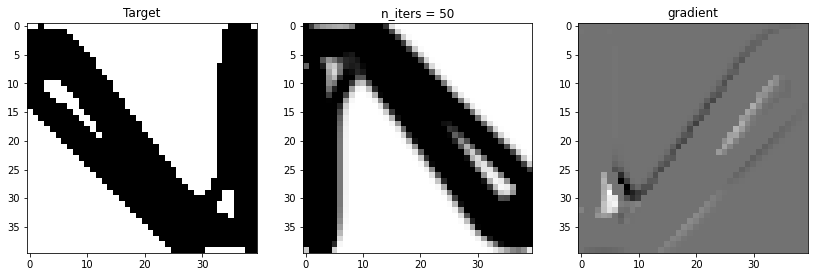

In [ ]:
num = 55
plt.figure(figsize = (14,11))
plt.subplot(1,3,1)
plt.title(f'Target')
plt.imshow(TF.hflip(check[num][1][0]), cmap= 'binary')

plt.subplot(1,3,2)
plt.title(f'n_iters = {check.cur_iter}')
plt.imshow(TF.vflip(check[num][0][0]), cmap= 'binary')

plt.subplot(1,3,3)
plt.title(f'gradient')
plt.imshow(check[num][0][1], cmap= 'binary')

In [ ]:
train_set = []
test_set = []

In [ ]:
for i in range(int(0.8*len(check))):
  try:
    train_set.append(check[i])
  except:
    continue

In [ ]:
for i in range(int(0.8*len(check)), len(check)):
  try:
    test_set.append(check[i])
  except:
    continue

In [ ]:
print(len(train_set))
print(len(test_set))
print(len(train_set) + len(test_set))

7985
1996
9981


In [ ]:
for i in range(len(train_set)):
    if random.random() > 0.2:
        train_set.append((
            torch.from_numpy(np.concatenate(
                (train_set[i][0][0].T.view(1,40,40), train_set[i][0][1].T.view(1,40,40))
            )), train_set[i][1].view(40,40).T.view(1,40,40)
        )
        )

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=100, shuffle = True)
test_loader = DataLoader(dataset=test_set, batch_size=100, shuffle = True)

In [ ]:
features = [128,256,512]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = UNET(in_channels = 2, out_channels=1, features=features).to(device)

In [ ]:
learning_rate = 1e-4
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_epochs = 100

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer= optimizer, gamma=0.5, verbose = True)

test_arr = []

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
#         print(images.shape, labels.shape)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss1 = criterion1(outputs, labels)
        loss2 = criterion2(outputs, labels)
        loss = loss1 + loss2
        # backward
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 1 ==0:
         
            print(f'epoch {epoch+1} / {n_epochs}, step {i+1}/{len(train_loader)}, loss = {loss.item():.6f}')
    # scheduler.step()
    test_arr.append(check_accuracy(test_loader, model))

Adjusting learning rate of group 0 to 1.0000e-04.
epoch 1 / 100, step 1/145, loss = 1.045101
epoch 1 / 100, step 2/145, loss = 1.032368
epoch 1 / 100, step 3/145, loss = 1.041106
epoch 1 / 100, step 4/145, loss = 1.034771
epoch 1 / 100, step 5/145, loss = 1.037130
epoch 1 / 100, step 6/145, loss = 1.042236
epoch 1 / 100, step 7/145, loss = 1.031811
epoch 1 / 100, step 8/145, loss = 1.031056
epoch 1 / 100, step 9/145, loss = 1.045372
epoch 1 / 100, step 10/145, loss = 1.044556
epoch 1 / 100, step 11/145, loss = 1.040291
epoch 1 / 100, step 12/145, loss = 1.031210
epoch 1 / 100, step 13/145, loss = 1.035430
epoch 1 / 100, step 14/145, loss = 1.033798
epoch 1 / 100, step 15/145, loss = 1.022149
epoch 1 / 100, step 16/145, loss = 1.041369
epoch 1 / 100, step 17/145, loss = 1.036180
epoch 1 / 100, step 18/145, loss = 1.042406
epoch 1 / 100, step 19/145, loss = 1.040468
epoch 1 / 100, step 20/145, loss = 1.039768
epoch 1 / 100, step 21/145, loss = 1.037549
epoch 1 / 100, step 22/145, loss = 

KeyboardInterrupt: ignored

In [ ]:
checkpoint = {
    "model_state": model.state_dict(),
    "features": features,
    "optim_state": optimizer.state_dict()
}

In [ ]:
torch.save(model.state_dict(), "model_colab_80.pth")

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    jaccard = JaccardIndex(num_classes=2, task = 'binary').to(device)
    iou = 0
    with torch.no_grad():
        for x,y in loader:
            y = y.to(device)
            x = x.to(device)
            preds = model(x)
            preds = (preds > 0.5).float()
            num_correct +=  (preds ==y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum())
            iou += jaccard(preds, y)
    
    print(f'Cur_iter - {check.cur_iter}')
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader) * 100:.2f}")
    print(f"IoU: {iou/len(loader) * 100:.2f}")

In [ ]:
check_accuracy(train_loader, model)

Got 22988466/23049600 with acc 99.73
Dice score: 0.9972845911979675
IoU: 0.9945846199989319


In [ ]:
check_accuracy(test_loader, model)

Got 3185224/3195200 with acc 99.69
Dice score: 0.9968224763870239
IoU: 0.9936651587486267
